In [1]:
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd 
import numpy as np
import os

def read_data(data_path, split = "train"):
	""" Read data """

	# Fixed params
	n_class = 6
	n_steps = 128

	# Paths
	path_ = os.path.join(data_path, split)
	path_signals = os.path.join(path_, "Inertial_Signals")

	# Read labels and one-hot encode
	label_path = os.path.join(path_, "y_" + split + ".txt")
	labels = pd.read_csv(label_path, header = None)

	# Read time-series data
	channel_files = os.listdir(path_signals)
	channel_files.sort()
	n_channels = len(channel_files)
	posix = len(split) + 5

	# Initiate array
	list_of_channels = []
	X = np.zeros((len(labels), n_steps, n_channels))
	i_ch = 0
	for fil_ch in channel_files:
		channel_name = fil_ch[:-posix]
		dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
		X[:,:,i_ch] = dat_.as_matrix()

		# Record names
		list_of_channels.append(channel_name)

		# iterate
		i_ch += 1

	# Return 
	return X, labels[0].values, list_of_channels

# test and train read
Xtrain, Ytrain, _ = read_data(data_path="/home/arasdar/datasets/har/har-data/", split="train")
Xtest, Ytest, _ = read_data(data_path="/home/arasdar/datasets/har/har-data/", split="test")

In [2]:
# # standardizing/normalizing the train and test data
# def standardize(train, test):
# """ Standardize data """
# # Standardize train and test
# X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
# X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]
# return X_train, X_test

Xtrain = (Xtrain - Xtrain.mean(axis=0))/ Xtrain.std(axis=0)
Xtest = (Xtest - Xtest.mean(axis=0))/ Xtest.std(axis=0)
print(Xtrain.shape, Xtrain.dtype)
print(Xtest.shape, Xtest.dtype)

(7352, 128, 9) float64
(2947, 128, 9) float64


In [3]:
print(Xtrain.mean(axis=0), Xtrain.std(axis=0))

[[ 7.29829690e-17 -1.02082531e-17  1.57352066e-17 ... -4.98687012e-15
   1.85772084e-16  1.49046535e-16]
 [-3.78883238e-17 -3.43169454e-17  2.59223183e-16 ...  1.22050349e-15
   4.80512740e-17 -4.62565242e-16]
 [ 1.84533805e-17 -2.06052682e-17 -3.44906065e-17 ... -2.15841883e-16
   2.85362956e-16 -3.28763132e-16]
 ...
 [ 4.40797199e-17 -2.73629505e-17 -1.20505709e-17 ...  5.30356876e-15
   5.48165068e-17 -3.37113966e-16]
 [ 2.29534684e-17  5.79273058e-17  8.81896418e-18 ...  2.48264790e-15
  -1.15794208e-16  4.64958745e-17]
 [ 4.27810368e-17  1.22921864e-17 -3.12589997e-17 ... -1.67407304e-15
   1.10599475e-16 -3.55174722e-16]] [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [4]:
print(Xtest.mean(axis=0), Xtest.std(axis=0))

[[ 7.16540276e-17  1.80830354e-17  2.95356244e-17 ... -4.00445992e-15
   3.99333697e-17  2.13869566e-16]
 [ 5.58878811e-17  3.33782694e-17  5.28928784e-17 ...  6.23404167e-15
   7.13526437e-17 -1.22135835e-16]
 [ 1.11512051e-17  8.43874983e-18  4.68652000e-17 ... -2.75390501e-15
  -1.09251672e-17 -8.88329112e-17]
 ...
 [ 1.58980019e-17 -3.98580238e-17  3.31522315e-18 ... -1.33149533e-15
   6.84894964e-17 -1.86330610e-16]
 [ 4.07810120e-17  5.57277709e-17  3.27001556e-17 ...  3.11386101e-16
   1.40520254e-17 -2.61751937e-16]
 [ 9.20162788e-18 -4.68275270e-17 -4.47555125e-17 ... -1.35942986e-16
   4.69028729e-17  2.26923257e-16]] [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [5]:
# Onehotencoding of the output labels
def onehot(labels, n_class):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y

print(Ytrain.max(axis=0), Ytest.max(axis=0))
# # assert Y.max(axis=0) == Ytrain.max(axis=0) == Ytest.max(axis=0), 'wrong labels'
Ytrain=onehot(labels=Ytrain, n_class=Ytrain.max(axis=0))
Ytest=onehot(labels=Ytest, n_class=Ytest.max(axis=0))
print(Ytrain.shape, Ytrain.dtype, Ytest.shape, Ytest.dtype)

6 6
(7352, 6) float64 (2947, 6) float64


In [6]:
from sklearn.model_selection import train_test_split

# Now separating train and validation set
# 30% of the training data/ entire training data is assigned to validation.
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=0.30)
print(Xtrain.shape, Xvalid.shape, Xtest.shape, Xtrain.dtype, Xvalid.dtype, Xtest.dtype)
print(Ytrain.shape, Yvalid.shape, Ytest.shape, Ytrain.dtype, Yvalid.dtype, Ytest.dtype)

(5146, 128, 9) (2206, 128, 9) (2947, 128, 9) float64 float64 float64
(5146, 6) (2206, 6) (2947, 6) float64 float64 float64


In [7]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [8]:
# now I can design the actual input and output tensors
N, W, Cin = Xvalid.shape[0], Xvalid.shape[1], Xvalid.shape[2]
X = tf.placeholder(dtype=tf.float32, name=None, shape=[N, W, Cin])
print(X.shape, X.dtype, Xtrain.shape, Xtrain.dtype, Xvalid.shape, Xvalid.dtype, Xtest.shape, Xtest.dtype)

(2206, 128, 9) <dtype: 'float32'> (5146, 128, 9) float64 (2206, 128, 9) float64 (2947, 128, 9) float64


In [9]:
# This is the output tensor for labels
N, Cout = Yvalid.shape[0], Yvalid.shape[1]
Y = tf.placeholder(dtype=tf.float32, name=None, shape=[N, Cout])
print(Y.shape, Y.dtype, Ytrain.shape, Ytrain.dtype, Yvalid.shape, Yvalid.dtype, Ytest.shape, Ytest.dtype)

(2206, 6) <dtype: 'float32'> (5146, 6) float64 (2206, 6) float64 (2947, 6) float64


In [30]:
print(X.shape, X.dtype)
Wwidth, Wchannels, Wnumber = X.shape[1].value//2, X.shape[2].value, X.shape[2].value*2
shape = [Wwidth, Wchannels, Wnumber]
initial_value = tf.random_normal(dtype=X.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
Wconv = tf.Variable(dtype=X.dtype, initial_value=initial_value, name=None, trainable=True)
print(Wconv.shape, Wconv.dtype)
Xconv = tf.nn.conv1d(data_format='NWC', filters=Wconv, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=X)
Xconv = tf.maximum(name=None, x=(-0.1*Xconv), y=Xconv)
print(Xconv.shape, Xconv.dtype)

(2206, 128, 9) <dtype: 'float32'>
(64, 9, 18) <dtype: 'float32_ref'>
(2206, 64, 18) <dtype: 'float32'>


In [31]:
# This is the multiplication layer
# this part is flatening the input
shape = [Xconv.shape[0].value, Xconv.shape[1].value*Xconv.shape[2].value]
Xconv_reshaped = tf.reshape(name=None, shape=shape, tensor=Xconv)
print(Xconv_reshaped.shape, Xconv_reshaped.dtype)
# their first axis or dimension stay the same
shape = [Xconv_reshaped.shape[1].value, Y.shape[1].value]
initial_value = tf.random_normal(dtype=Xconv_reshaped.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
W = tf.Variable(dtype=Xconv_reshaped.dtype, initial_value=initial_value, name=None, trainable=True)
print(W.shape, W.dtype)
# The actual multiplication
# Y_ = Xconv_reshaped @ W
Y_ = tf.matmul(a=Xconv_reshaped, b=W, name=None)
print(Y_.shape, Y_.dtype)
print(Y.shape, Y.dtype)

(2206, 1152) <dtype: 'float32'>
(1152, 6) <dtype: 'float32_ref'>
(2206, 6) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [32]:
# Now I need to calculate the loss
loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=Y_, name=None)
print(loss_tensor.shape, loss_tensor.dtype)
loss = tf.reduce_mean(axis=0, input_tensor=loss_tensor, name=None)
print(loss)

(2206,) <dtype: 'float32'>
Tensor("Mean_2:0", shape=(), dtype=float32)


In [33]:
# Backprop and SGD now using adam
opt = tf.train.AdamOptimizer().minimize(loss)
print(opt)

name: "Adam_1"
op: "NoOp"
input: "^Adam_1/update_Variable_2/ApplyAdam"
input: "^Adam_1/update_Variable_3/ApplyAdam"
input: "^Adam_1/Assign"
input: "^Adam_1/Assign_1"



In [34]:
print(Y_.shape, Y_.dtype, Y.shape, Y.dtype)

(2206, 6) <dtype: 'float32'> (2206, 6) <dtype: 'float32'>


In [35]:
# Accuracy
# tf.argmax(
#     input,
#     axis=None,
#     name=None,
#     dimension=None,
#     output_type=tf.int64
# )
# Y_NxCout, N:axis 1, Cout: axis 2
Y_argmax = tf.argmax(axis=1, name=None, input=Y_, output_type=tf.int32)
print(Y_argmax.shape, Y_argmax.dtype)
# # tf.nn.softmax(
# #     logits,
# #     axis=None,
# #     name=None,
# #     dim=None
# # )
# # softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis)
print(Y.shape, Y.dtype)
Yargmax = tf.argmax(axis=1, input=Y, name=None, output_type=tf.int32)
print(Yargmax.shape, Yargmax.dtype)

acc_tensor = tf.equal(name=None, x=Y_argmax, y=Yargmax)
print(acc_tensor.shape, acc_tensor.dtype)
# cast bool to int datatype for equal
acc_tensor = tf.cast(dtype=tf.float32, name=None, x=acc_tensor)
print(acc_tensor.shape, acc_tensor.dtype)
acc = tf.reduce_mean(axis=0, input_tensor=acc_tensor)
print(acc.shape, acc.dtype)

(2206,) <dtype: 'int32'>
(2206, 6) <dtype: 'float32'>
(2206,) <dtype: 'int32'>
(2206,) <dtype: 'bool'>
(2206,) <dtype: 'float32'>
() <dtype: 'float32'>


In [36]:
def get_batches(X, Y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, Y = X[:n_batches*batch_size], Y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], Y[b:b+batch_size]

In [26]:
# We should save the after training and validation
saver = tf.train.Saver() 
train_loss_mean, valid_loss_mean = [], []
train_acc_mean, valid_acc_mean = [], []

# now that we can calculate loss and optimize, we can start a session for calculating the error.
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
    
    # for every epoch start feeding the arrays into the tensors in the model
    for epoch in range(0, 200, 1):
        train_loss, valid_loss = [], []
        train_acc, valid_acc = [], []
        
        # Training minibatches and feed them into the tensor
        for Xarr, Yarr in get_batches(X=Xtrain, Y=Ytrain, batch_size=Xvalid.shape[0]):
            # X_NxWxCin, Y_NxCout
            feed_dict = {X:Xarr, Y:Yarr}
            lossarr, _, accarr = sess.run(feed_dict=feed_dict, fetches=[loss, opt, acc])
            train_loss.append(lossarr)
            train_acc.append(accarr)
            
        # Validation now which is one batch on every iteration
        for Xarr, Yarr in get_batches(X=Xvalid, Y=Yvalid, batch_size=Xvalid.shape[0]): 
            # X_NxWxCin, Y_NxCout
            feed_dict = {X:Xarr, Y:Yarr}
            lossarr, accarr = sess.run(feed_dict=feed_dict, fetches=[loss, acc])
            valid_loss.append(lossarr)
            valid_acc.append(accarr)
        
        # printing out train and validation loss
        print('epoch:', epoch+1, 'train_loss:', np.mean(train_loss), 'valid_loss:', np.mean(valid_loss),
             'train_acc:', np.mean(train_acc), 'valid_acc:', np.mean(valid_acc))
        
        # Every epoch, for drawing the plot and their learning curve
        train_loss_mean.append(np.mean(train_loss))
        valid_loss_mean.append(np.mean(valid_loss))
        train_acc_mean.append(np.mean(train_acc))
        valid_acc_mean.append(np.mean(valid_acc))
        
    # After all epochs and at the end of training and validation
    saver.save(sess,'checkpoints/cnn-imu-har.ckpt')

epoch: 1 train_loss: 670.65674 valid_loss: 645.3366 train_acc: 0.15208521 valid_acc: 0.1536718
epoch: 2 train_loss: 630.3382 valid_loss: 605.8904 train_acc: 0.15797824 valid_acc: 0.15911151
epoch: 3 train_loss: 592.2117 valid_loss: 569.2757 train_acc: 0.16500452 valid_acc: 0.17951043
epoch: 4 train_loss: 556.8845 valid_loss: 537.3931 train_acc: 0.19424298 valid_acc: 0.24660018
epoch: 5 train_loss: 526.693 valid_loss: 510.95224 train_acc: 0.2620127 valid_acc: 0.28331822
epoch: 6 train_loss: 500.9778 valid_loss: 487.4283 train_acc: 0.28717136 valid_acc: 0.2978241
epoch: 7 train_loss: 477.71582 valid_loss: 466.00247 train_acc: 0.29873073 valid_acc: 0.30825022
epoch: 8 train_loss: 456.794 valid_loss: 446.57397 train_acc: 0.31233 valid_acc: 0.32003626
epoch: 9 train_loss: 437.79974 valid_loss: 428.97012 train_acc: 0.31912965 valid_acc: 0.32456934
epoch: 10 train_loss: 420.33344 valid_loss: 412.98056 train_acc: 0.32456934 valid_acc: 0.32502267
epoch: 11 train_loss: 404.21527 valid_loss: 398.

epoch: 90 train_loss: 85.62344 valid_loss: 111.8664 train_acc: 0.64392567 valid_acc: 0.61060745
epoch: 91 train_loss: 84.352234 valid_loss: 110.75596 train_acc: 0.64687216 valid_acc: 0.6142339
epoch: 92 train_loss: 83.10892 valid_loss: 109.67498 train_acc: 0.65231186 valid_acc: 0.618767
epoch: 93 train_loss: 81.89351 valid_loss: 108.63427 train_acc: 0.65548503 valid_acc: 0.62148684
epoch: 94 train_loss: 80.70171 valid_loss: 107.62333 train_acc: 0.6582049 valid_acc: 0.6237534
epoch: 95 train_loss: 79.53734 valid_loss: 106.64064 train_acc: 0.66251135 valid_acc: 0.62692654
epoch: 96 train_loss: 78.39294 valid_loss: 105.666725 train_acc: 0.66568446 valid_acc: 0.63055307
epoch: 97 train_loss: 77.264465 valid_loss: 104.69458 train_acc: 0.6681777 valid_acc: 0.6337262
epoch: 98 train_loss: 76.15454 valid_loss: 103.72332 train_acc: 0.67135084 valid_acc: 0.63644606
epoch: 99 train_loss: 75.06148 valid_loss: 102.758965 train_acc: 0.675204 valid_acc: 0.63689935
epoch: 100 train_loss: 73.98395 vali

epoch: 177 train_loss: 24.851437 valid_loss: 55.348473 train_acc: 0.8277426 valid_acc: 0.74886674
epoch: 178 train_loss: 24.519058 valid_loss: 55.02217 train_acc: 0.82864916 valid_acc: 0.75158656
epoch: 179 train_loss: 24.193146 valid_loss: 54.70463 train_acc: 0.8309157 valid_acc: 0.7524932
epoch: 180 train_loss: 23.875069 valid_loss: 54.400936 train_acc: 0.8322756 valid_acc: 0.7556664
epoch: 181 train_loss: 23.562023 valid_loss: 54.105045 train_acc: 0.8329556 valid_acc: 0.75611967
epoch: 182 train_loss: 23.253464 valid_loss: 53.80928 train_acc: 0.83431554 valid_acc: 0.75611967
epoch: 183 train_loss: 22.951523 valid_loss: 53.515076 train_acc: 0.8363554 valid_acc: 0.7579329
epoch: 184 train_loss: 22.657883 valid_loss: 53.22886 train_acc: 0.838622 valid_acc: 0.7583862
epoch: 185 train_loss: 22.37156 valid_loss: 52.952473 train_acc: 0.83998185 valid_acc: 0.75883955
epoch: 186 train_loss: 22.087234 valid_loss: 52.678143 train_acc: 0.84043515 valid_acc: 0.75883955
epoch: 187 train_loss: 21.

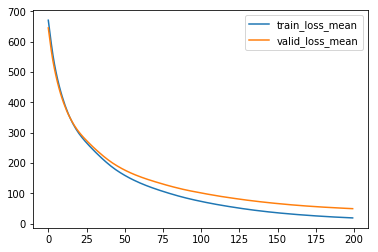

In [27]:
import matplotlib.pyplot as mplot
%matplotlib inline

mplot.plot(train_loss_mean, label='train_loss_mean')
mplot.plot(valid_loss_mean, label='valid_loss_mean')
mplot.legend()

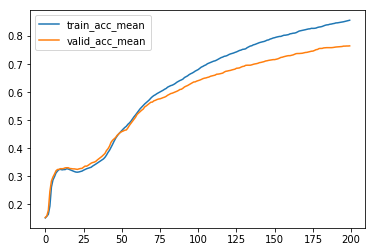

In [28]:
mplot.plot(train_acc_mean, label='train_acc_mean')
mplot.plot(valid_acc_mean, label='valid_acc_mean')
mplot.legend()

In [29]:
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
    
    # Loading the trained and validated model
    saver.restore(save_path=tf.train.latest_checkpoint(checkpoint_dir='checkpoints/'), sess=sess)
    
    # Saving the test loss for every batch/minibtch
    test_loss, test_acc = [], []
    
    # applying the loaded model on test data
    for Xarr, Yarr in get_batches(X=Xtest, Y=Ytest, batch_size=Xvalid.shape[0]): 
        # X_NxWXCin, Y_NxCout
        feed_dict={X:Xarr, Y:Yarr}
        lossarr, accarr = sess.run(feed_dict=feed_dict, fetches=[loss, acc])
        test_loss.append(lossarr)
        test_acc.append(accarr)
        
    # Printing the test loss
    print('test_loss:', np.mean(test_loss), 'test acc', np.mean(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/cnn-imu-har.ckpt
test_loss: 68.55156 test acc 0.6976428
